# COGS 108 - EDA Checkpoint

# Names

- Nhan Quach
- Joseph Morales
- Victor Wang
- Kevin Hu
- Areen Lu

<a id='research_question'></a>
# Research Question

How has social perception of profanity shifted across the past 20 years as indicated by the proportion of profane words utilized within the top 10 movies over the past 20 years and their respective age ratings, box office performance, and review scores?

# Setup

In [1]:
import pandas as pd
import numpy as np

# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=2, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
# set plotting size parameter
plt.rcParams['figure.figsize'] = (20, 10)

#import stat models
import statsmodels.api as sm
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.arima.model import ARIMA

# Data Cleaning

## Profane Words Data

In [ ]:
import csv

# Define a dictionary containing all relevant profane words to find
search_words = {'bastard': 0, 'bitch': 0, 'crap': 0, 'cunt': 0, 'damn': 0, 'fuck': 0, 'shit': 0, 'total': 0}

filename = "input_file.txt"

# Open the file for reading
with open(filename, "r") as file:
    # Loop through each line in the file
    for line in file:
        # Loop through each word in the dictionary
        for word in search_words:
            # Count the number of occurrences, including word substrings, in each line
            count = line.count(word)
            # If count is greater than zero, increment count for the word
            if count > 0:
                search_words[word] += count

# Sum all the values in the dictionary and add them to the 'total' key
search_words['total'] = sum(search_words.values())

# Drop the ".txt" extension from the input file name
file_basename = filename.split('.')[0]

# Write the contents of the dictionary to a CSV file
with open('search_words.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the headers to the first row of the CSV file
    headers = ['id'] + list(search_words.keys())
    writer.writerow(headers)
    # Write the values to the CSV file
    values = [file_basename] + list(search_words.values())
    writer.writerow(values)

The code above is used to search for profane words in a script file. The words to search for are stored in a dictionary called 'search_words'. In the script file, the code iterates through each line and counts all instances of the word or words as substrings. The count is incremented after each line. After reaching the end of the file, the total number of profane words is counted up and stored in the total key in the dictionary. The contents of the dictionary are written to a CSV file, where the first column is the ID of the script file without the '.txt' extension, and the remaining columns are the profane words and total count.

**Note:** Words such as 'ass', 'dick', 'pussy', and others were omitted as they could potentially result in false counts. For example, when looking for 'ass', words such as 'assumption', 'assign', 'class', and others would be counted although they are not profane words. Another example is 'pussy', where words like 'pussycat' would be counted despite not being used as profanity in a given context.

# Data Analysis & Results (EDA)

## Profane Words Data EDA

In [143]:
df = pd.read_csv('cleaned_data/movie_profane_words_count.csv')
df.head()

,id,bastard,bitch,crap,cunt,damn,fuck,shit,total
0,377062,2,1,2,0,6,1,30,42
1,1189340,1,10,0,0,7,4,18,40
2,120828,0,3,1,0,3,1,13,21
3,338013,0,1,5,0,7,30,18,61
4,460989,28,1,1,1,1,46,8,86


The data presented counts the number of profane words in each movie (represented by id) script. Each column counts the specified word and any words that contain the word as a substring. For example, words such as 'motherf-ker', 'f-ker', 'f-king', and 'f-k' would all be counted the same column.

In [145]:
column_sums = df.iloc[:, 1:-1].sum()
print(column_sums)

bastard     2144
bitch       6907
crap        2331
cunt         605
damn       12948
fuck       61294
shit       31991
dtype: int64


By counting the total number of words it each column, it is evident that the most commonly used words are 'sh-t', 'f-k', and 'd-mn'. The usage of these three words are approximately 10 times more frequent than other words on the list.

Text(0.5, 1.0, 'Frequency of Profane Words')

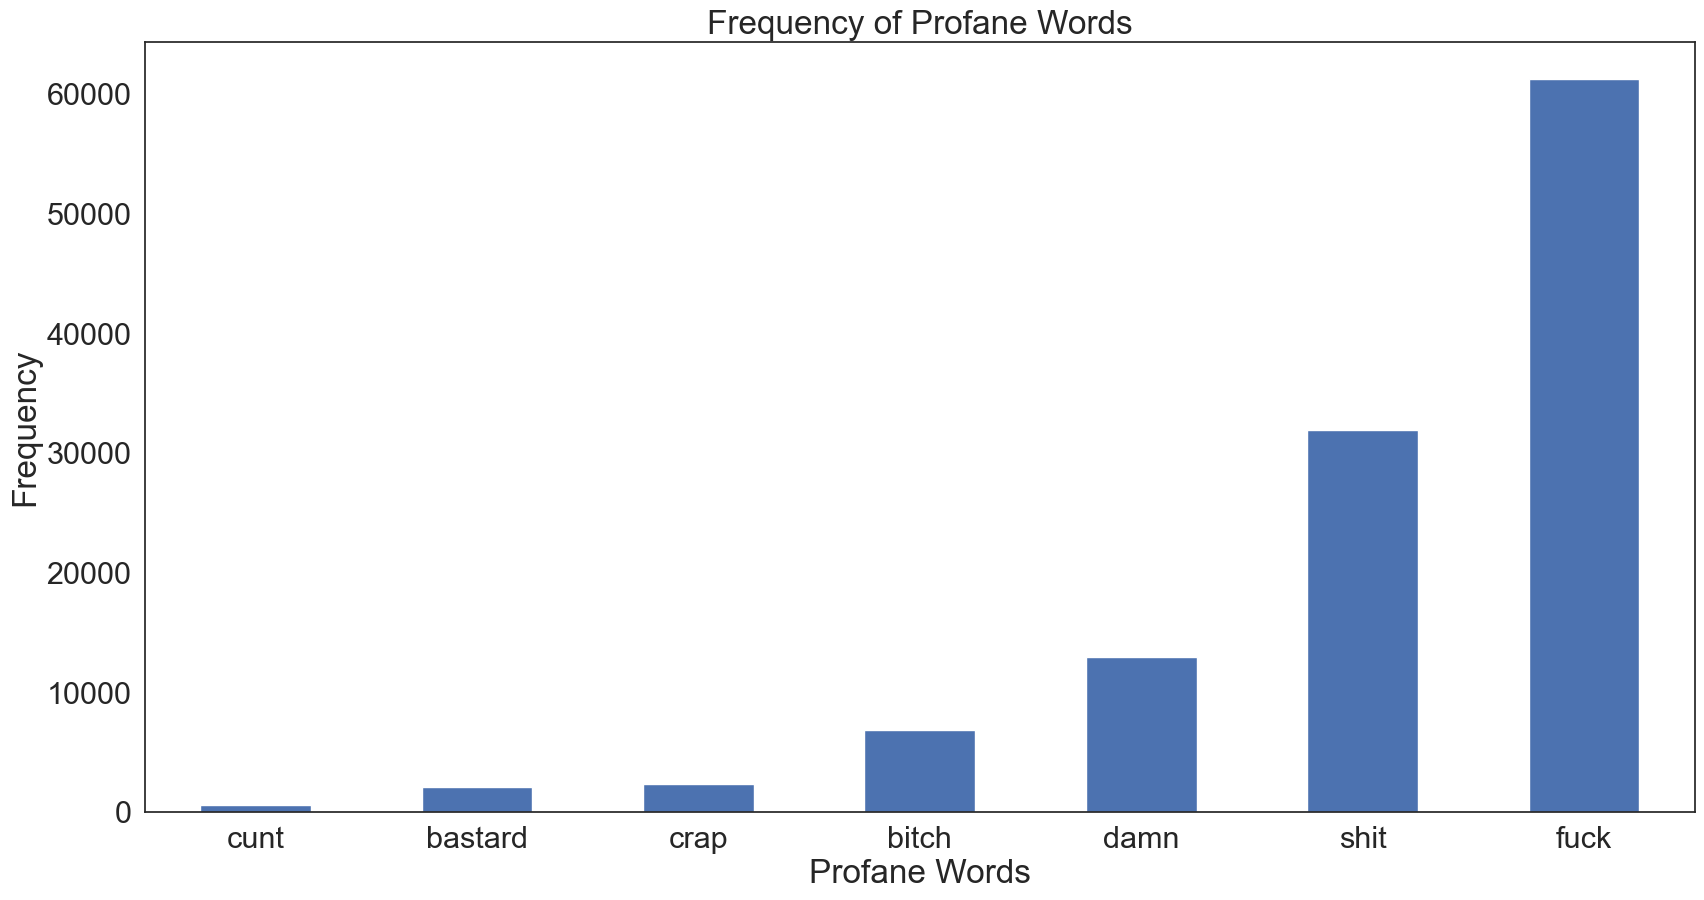

In [146]:
column_sums_sorted = column_sums.sort_values(ascending=True)
plt = column_sums_sorted.plot(kind='bar', rot=0)
plt.set_xlabel('Profane Words')
plt.set_ylabel('Frequency')
plt.set_title('Frequency of Profane Words')

From this chart, it is evident that the word 'f-k' is the the most frequently used word. The usage of this word is greater than the second and third words combined.

Text(0.5, 1.0, 'Most Used Word vs Total Words')

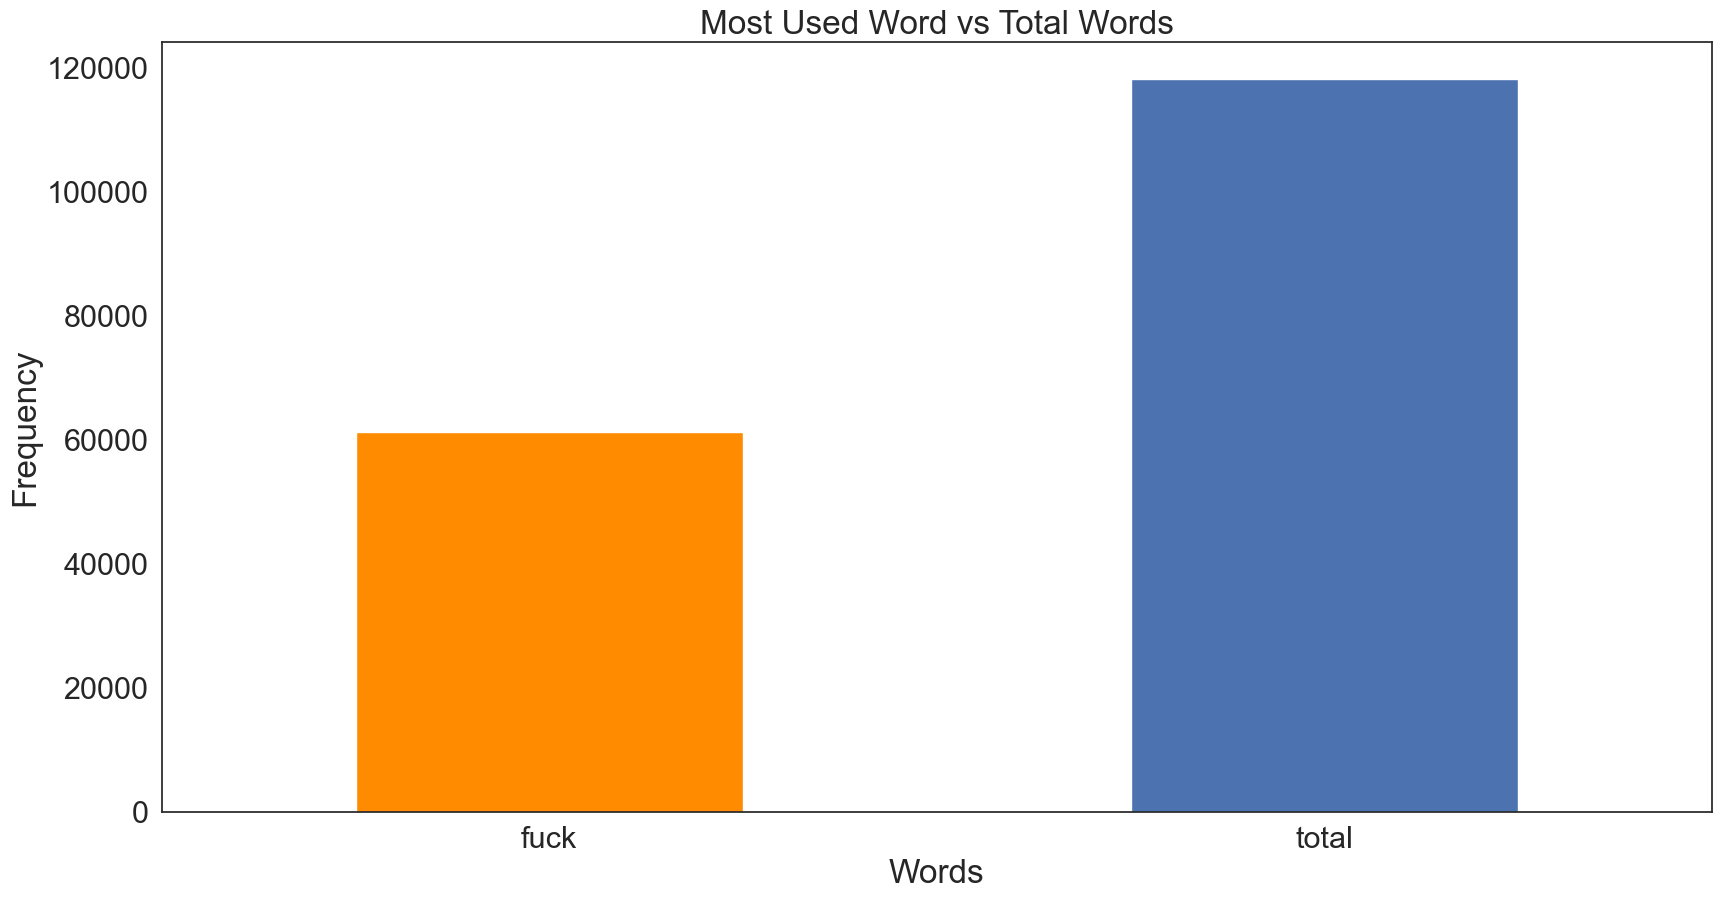

In [147]:
f_word_count = df['fuck'].sum()
total_word_count = df['total'].sum()

quantities = pd.Series([f_word_count, total_word_count], index=['fuck', 'total'])

colors = ['#FF8C00', '#4C72B0']
plt = quantities.plot(kind='bar', color=colors,  rot = 0)

plt.set_xlabel('Words')
plt.set_ylabel('Frequency')
plt.set_title('Most Used Word vs Total Words')

Comparing the total count of all profane words to the the total count of 'f-k', it can be seen how frequently this word appears. It accounts for approximately 60% of all profane words used.

(0.0, 677.0)

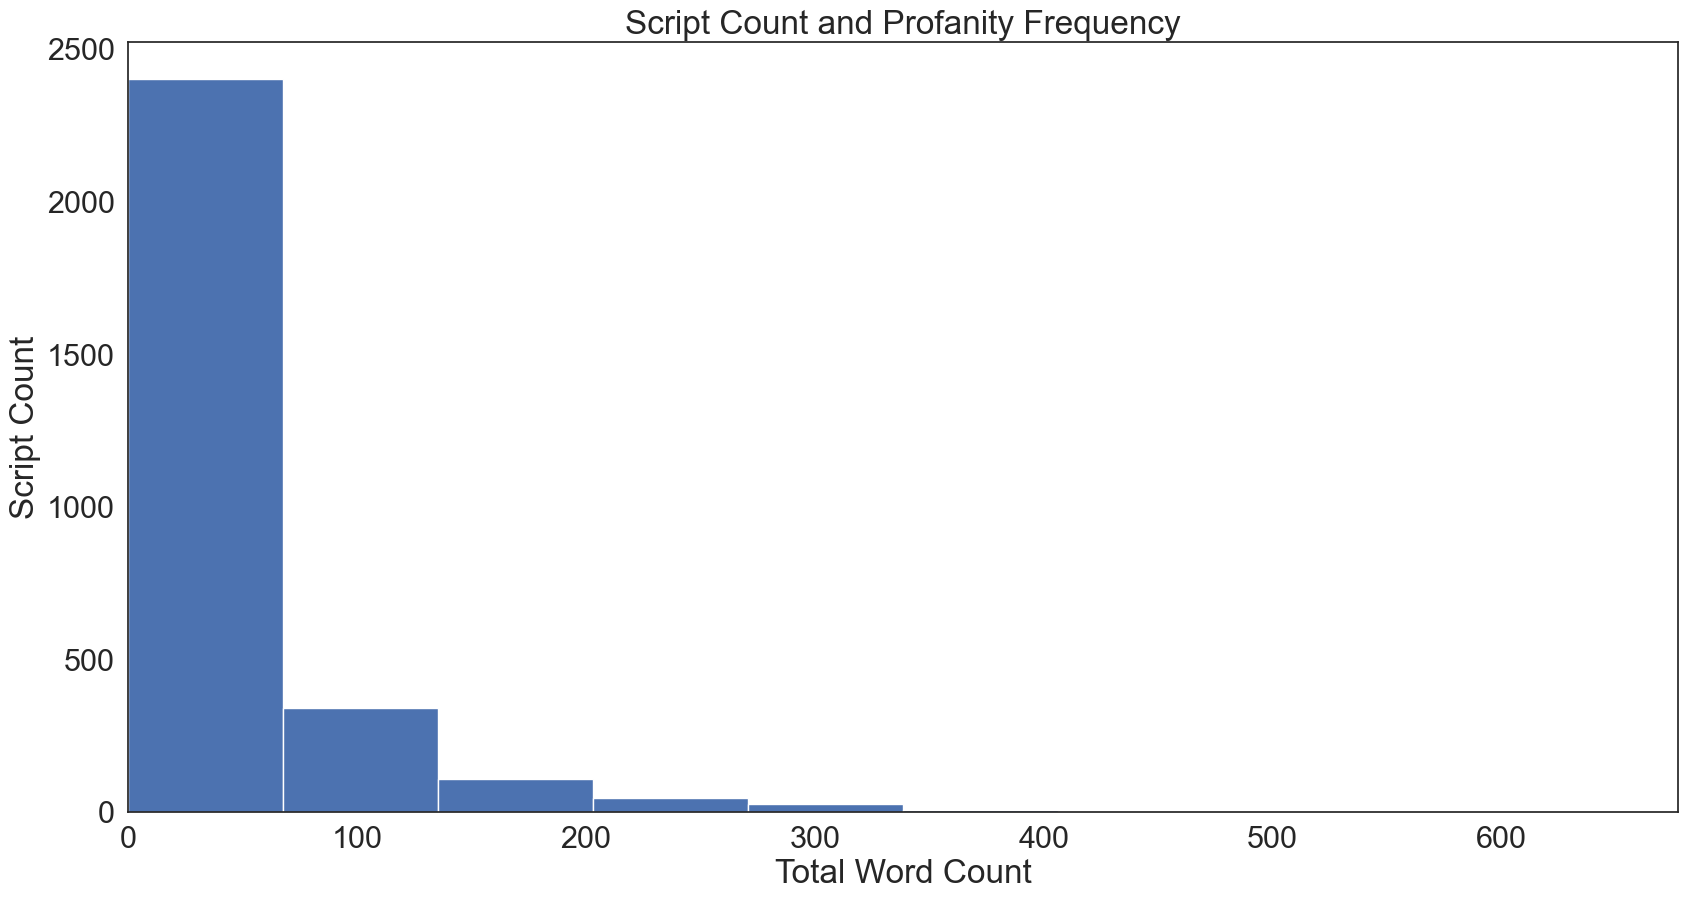

In [148]:
# create the histogram
total = df['total']
plt = total.plot(kind='hist', bins=10)

# set labels and title
plt.set_xlabel('Total Word Count')
plt.set_ylabel('Script Count')
plt.set_title('Script Count and Profanity Frequency')

plt.set_xlim([0,total.max()])

Most of the scripts in the dataset contain 50 or fewer profane words, with over 2000 scripts in this category. The second most common category is 50 to 100 profane words, but this only applies to less than 500 scripts. On the other end of the spectrum, there are a few scripts that contain over 600 profane words.

## Movie and Profane Words Data Analysis

In [2]:
#Read in CSVs
dfWords  = pd.read_csv('cleaned_data/movie_profane_words_count.csv')
dfMeta = pd.read_csv("cleaned_data/cleaned_metadata_2023-03-10_20-36-27.csv")

#Merge Profane words and metadata
dfMeta = dfMeta.rename(columns={"imdbId":"id"})
dfMeta["id"] = pd.to_numeric(dfMeta["id"])
dfWords["id"] = pd.to_numeric(dfWords["id"])
dfTotal = pd.merge(dfMeta,dfWords, on = "id")

#Getting proportion of profane words per script
dfTotal['normTotal'] = dfTotal['total']/dfTotal['script_size']

#Setting prediction dataset by
dfPredict = dfTotal.drop([254])

#Xticks
xy = [1997,2000,2003,2006,2009,2012,2015,2018]

Let's first take a look at the average number of profane words per movie from 1997 to 2017

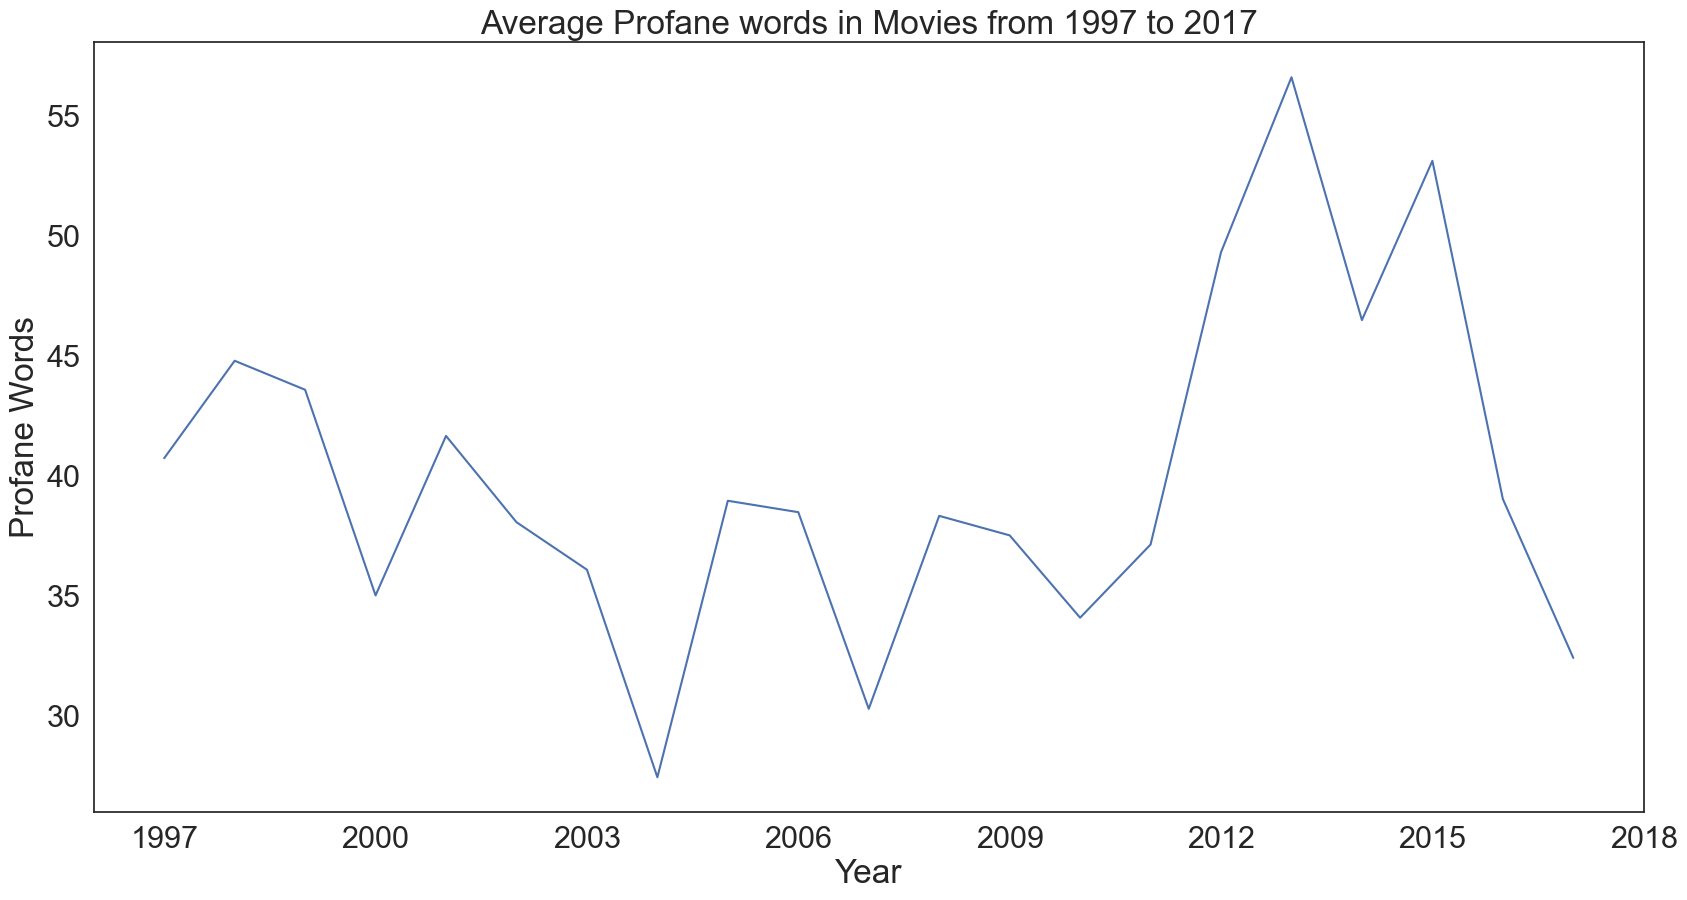

In [41]:
swearCountsMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['total'])
ax = sns.lineplot(data = swearCountsMean, x = "release_date", y = "total")
ax.set(title = "Average Profane words in Movies from 1997 to 2017",
       ylabel = "Profane Words",
       xlabel = "Year")
ax.set_xticks(xy)

Looking at the average number of profane words per movie we can see that there appears to be a slight downward trend over time from 1997 to 2011, with a sharp increase from 2011 to 2012 followed by a dropoff. This does not take into account the number of words in the script overall, however, which we can account for by looking at the proportion of profane words in a script.

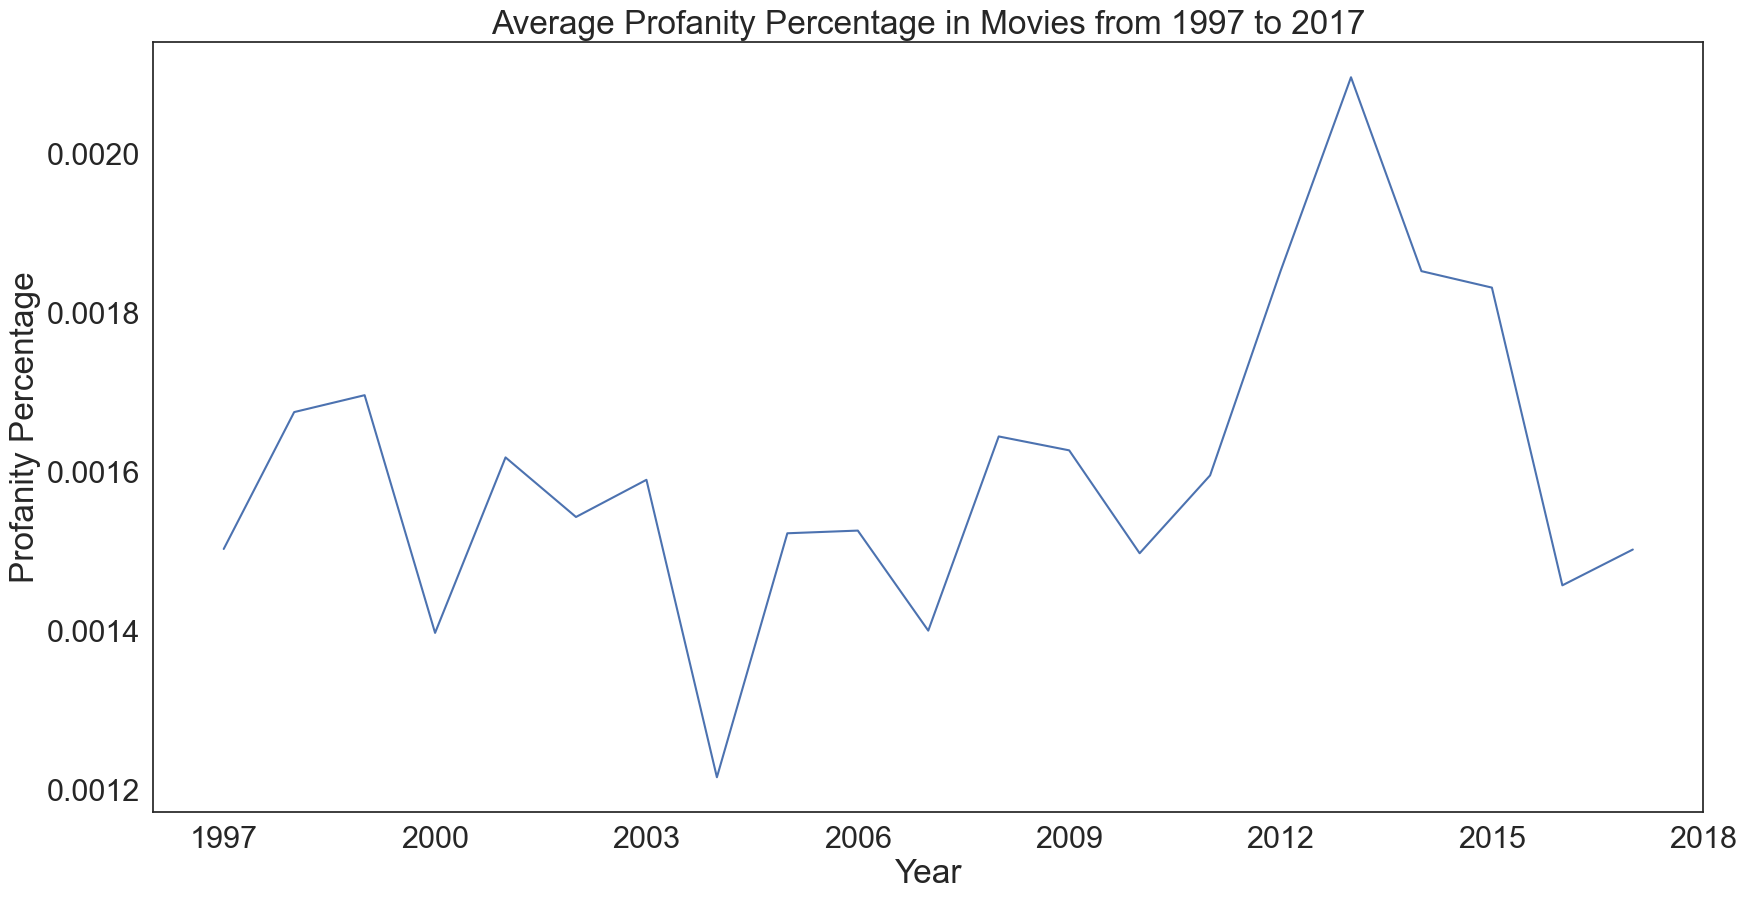

In [35]:
percentCountsMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['normTotal'])
ax = sns.lineplot(data = percentCountsMean, x = "release_date", y = "normTotal")
ax.set(title = "Average Profanity Percentage in Movies from 1997 to 2017",
       ylabel = "Profanity Percentage",
       xlabel = "Year")
ax.set_xticks(xy)

Looking at the proportional data, we can see that the downward trend from 1997 to 2011 disappears, with peaks and valleys up until the 2011 increase. Let's compare this trend with the average movie ratings over time as well. 

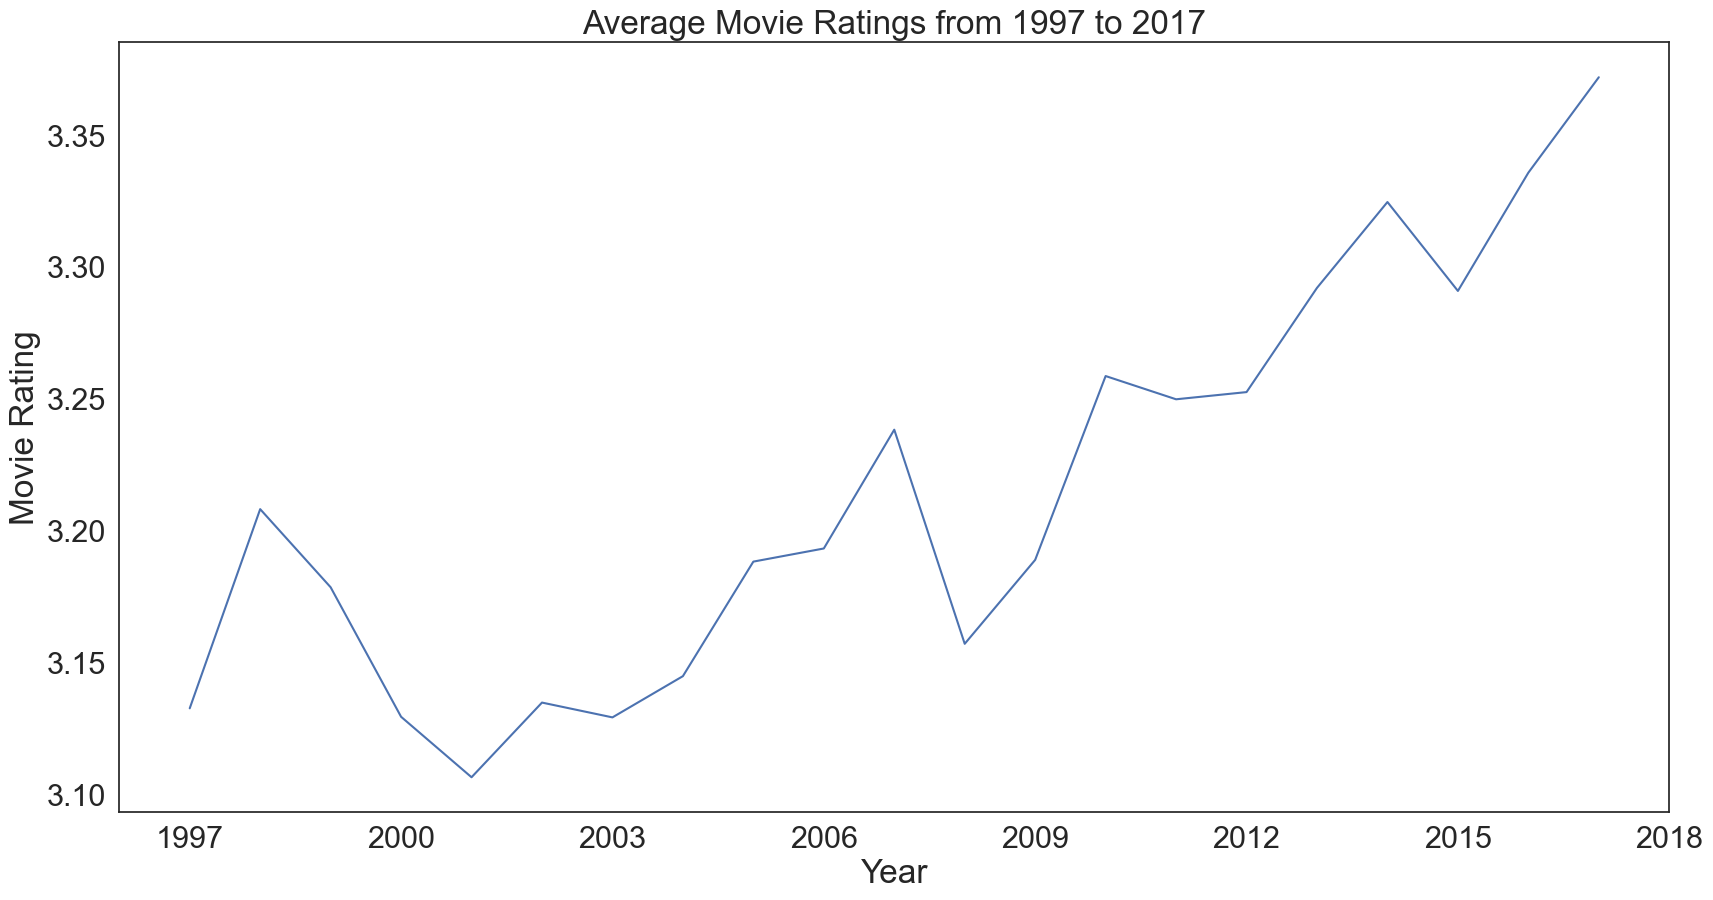

In [40]:
ratingsCountsMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['rating'])
ax = sns.lineplot(data = ratingsCountsMean, x = "release_date", y = "rating")
ax.set(title = "Average Movie Ratings from 1997 to 2017",
       ylabel = "Movie Rating",
       xlabel = "Year")
ax.set_xticks(xy)

Looking at the average movie ratings over time, we can see a peak and valley pattern from 1997 to 2007, followed by an increase in average movie ratings from 2007 onwards. Let's see the average box office revenue trends over the same time frame too.

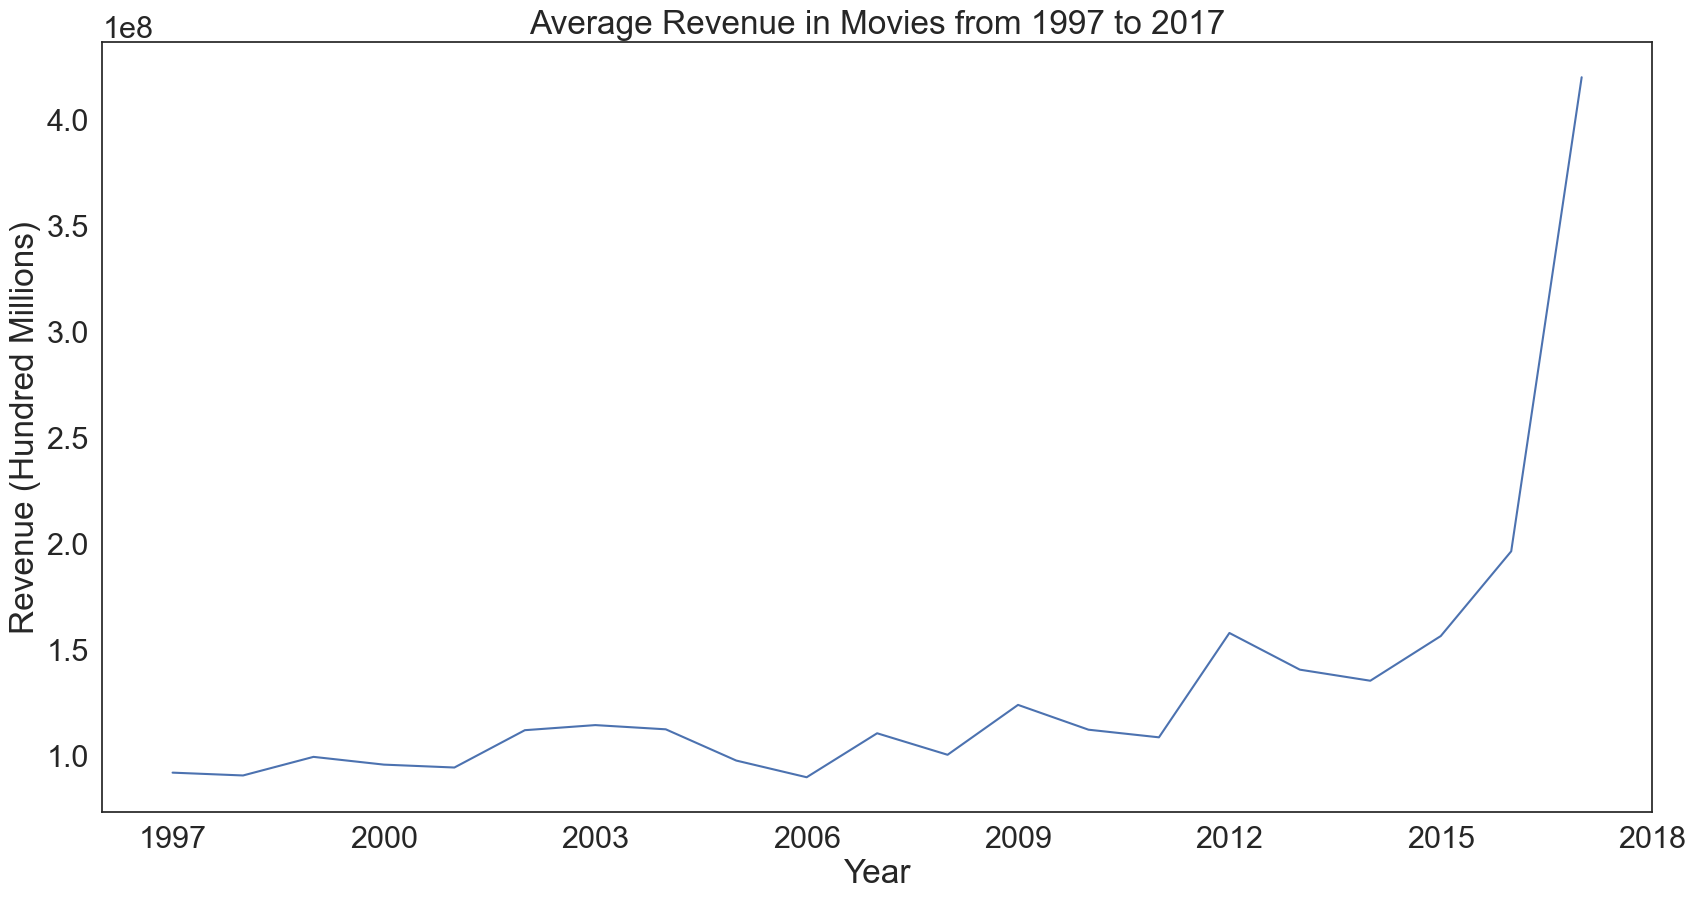

In [42]:
boxCountsMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['revenue'])
ax = sns.lineplot(data = boxCountsMean, x = "release_date", y = "revenue")
ax.set(title = "Average Revenue in Movies from 1997 to 2017",
       ylabel = "Revenue (Hundred Millions)",
       xlabel = "Year")
ax.set_xticks(xy)

Here, we can see a dramatic increase in the average revenue of movies from 2015 to 2017, an increase of $300,000,000 compared to the increase of $500,000 from 1997 to 2015. To see how these seperate trends in revenue and ratings compares to the trend in percantage of profane words per script over time, we can take a look at both a pearson and spearman correlaton matrix to identify the effect size between the different variables.

[Text(0.5, 1.0, 'Pearson Correlation')]

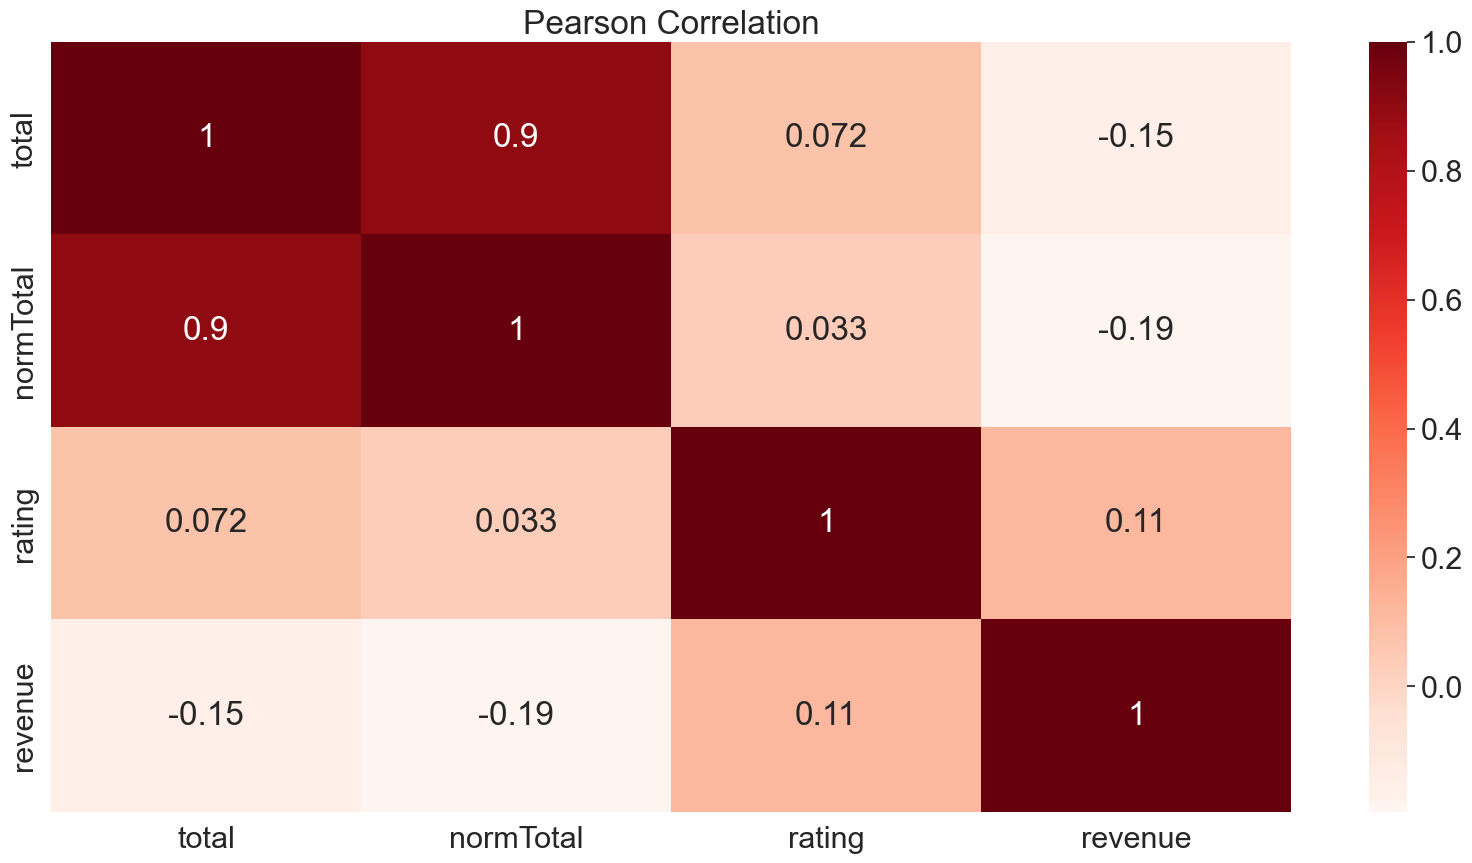

In [7]:
dfCorr = dfTotal[['total','normTotal','rating','revenue']]
cor = dfCorr.corr(method='pearson')
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
ax.set(title = "Pearson Correlation")

[Text(0.5, 1.0, 'Spearman Correlation')]

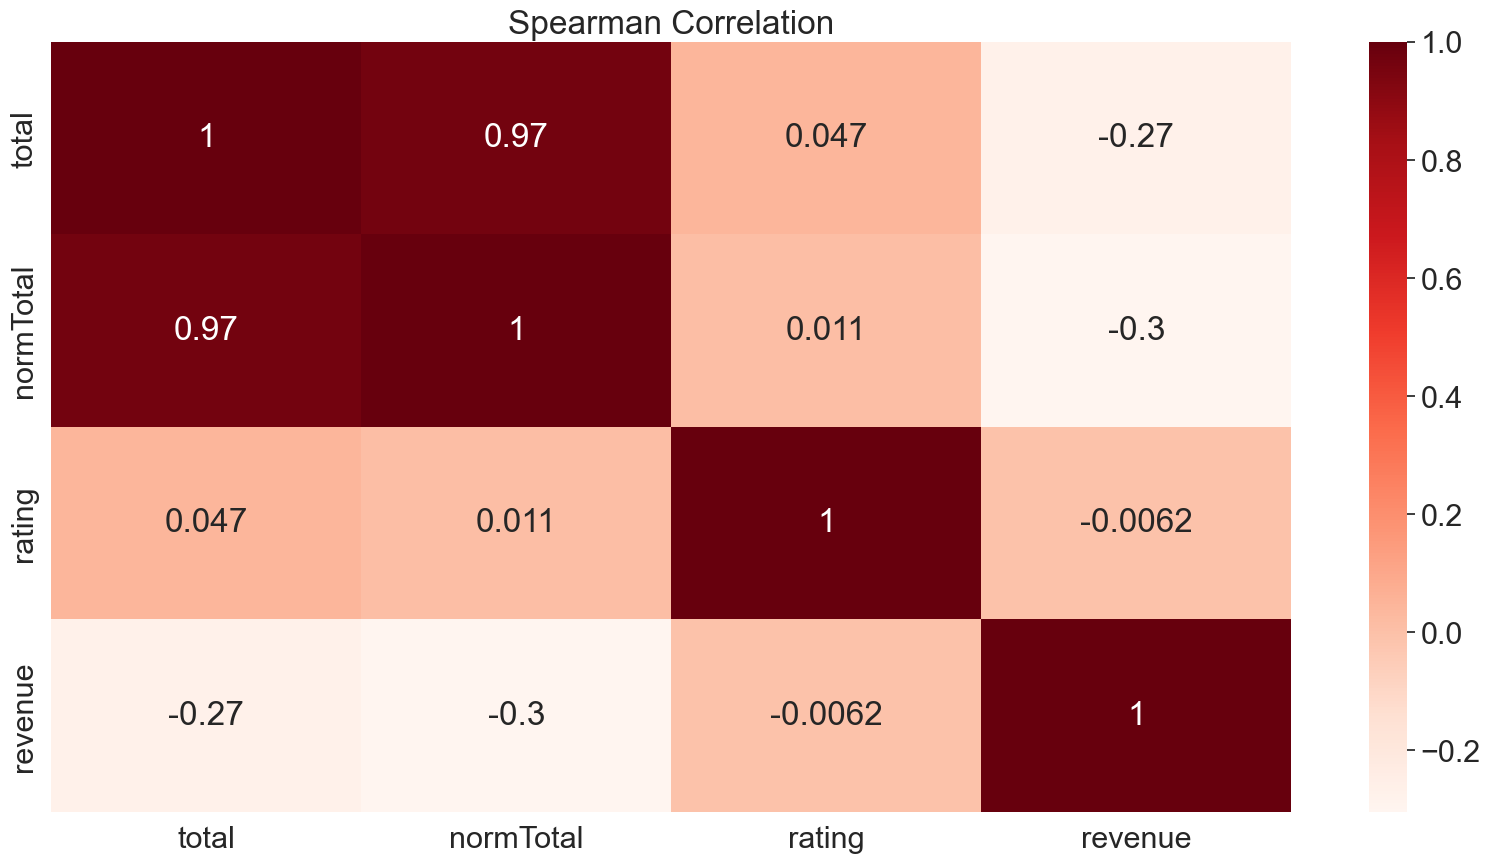

In [29]:
dfCorr = dfTotal[['total','normTotal','rating','revenue']]
cor = dfCorr.corr(method='spearman')
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
ax.set(title = "Spearman Correlation")

We can see that both the monotonic spearman correlations and the linear pearson correlations are weak(less than 0.3) for rating and revenue in relationship to profane percantages, so let's instead take a look at the relationships between each year's average instead. 

In [230]:
print(pearsonr(ratingsCountsMean['rating'],percentCountsMean['normTotal']))
print(pearsonr(boxCountsMean['revenue'],percentCountsMean['normTotal']))
print(spearmanr(percentCountsMean['normTotal'],boxCountsMean['revenue']))
print(spearmanr(percentCountsMean['normTotal'],ratingsCountsMean['rating']))

PearsonRResult(statistic=0.3477544230427529, pvalue=0.12241827432564542)
PearsonRResult(statistic=0.013443471168601007, pvalue=0.9538794838098523)
SpearmanrResult(correlation=0.16363636363636364, pvalue=0.4784743069143619)
SpearmanrResult(correlation=0.2155844155844156, pvalue=0.34796751366229983)


Here, we can see that the correlation with the strongest relationship if the pearson coefficent between the rating and the profane percant, suggesting a possible linear relationship between the two. However, we note that the p-value of 0.12 means that the result may not be strictly statistically significant and we note the possibility of random error at 12% to be higher than the typical 5%. Let's look at an OLS regression to explore this further.

In [290]:
x = percentCountsMean['normTotal']
y = ratingsCountsMean['rating']
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     2.614
Date:                Sun, 19 Mar 2023   Prob (F-statistic):              0.122
Time:                        21:04:10   Log-Likelihood:                 25.861
No. Observations:                  21   AIC:                            -47.72
Df Residuals:                      19   BIC:                            -45.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9909      0.139     21.456      0.0

/Users/victorwang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Rating versus profanity percentage from 1997 to 2017'),
 Text(0.5, 0, 'Profanity Percentage'),
 Text(0, 0.5, 'Movie Rating')]

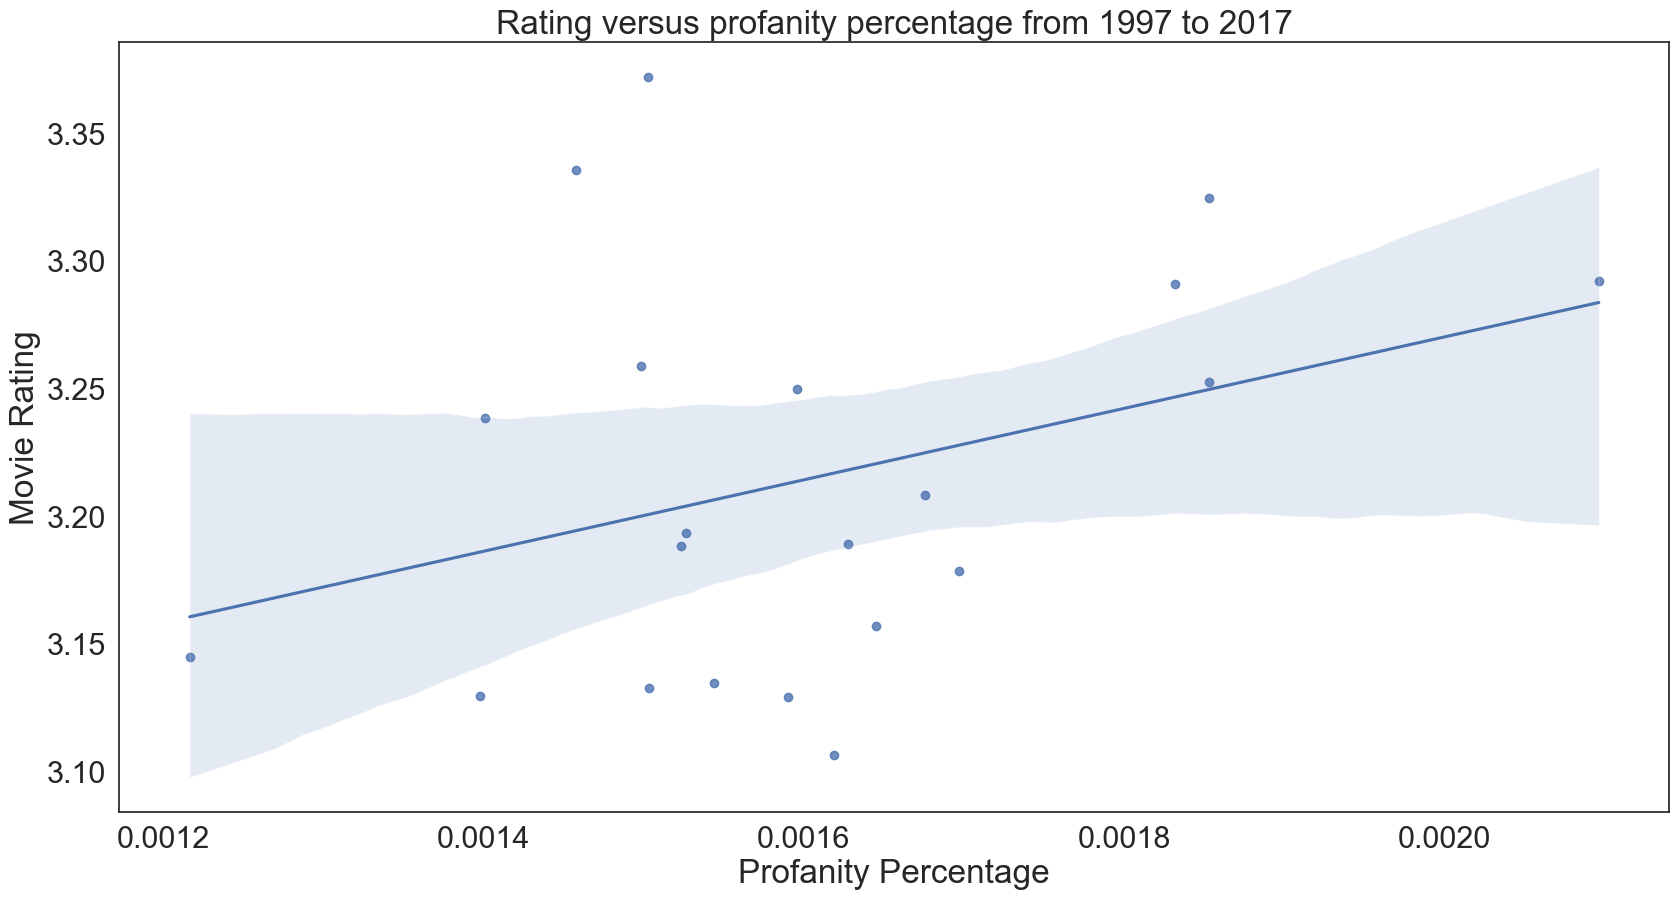

In [36]:
ax = sns.regplot(percentCountsMean['normTotal'], ratingsCountsMean['rating'])
ax.set(title = "Rating versus profanity percentage from 1997 to 2017",
       xlabel = "Profanity Percentage",
       ylabel = "Movie Rating")

Looking at the results of our regression, we can see that the R-squared of our regression is quite weak at 0.121. This suggests a weak relationship, with coupled with the higher p-value and lower pearson coefficent suggests that there exists little to no relationship between ratings and profanity percantage over time.

Let's take a look now at the MPAA age ratings of movies over time

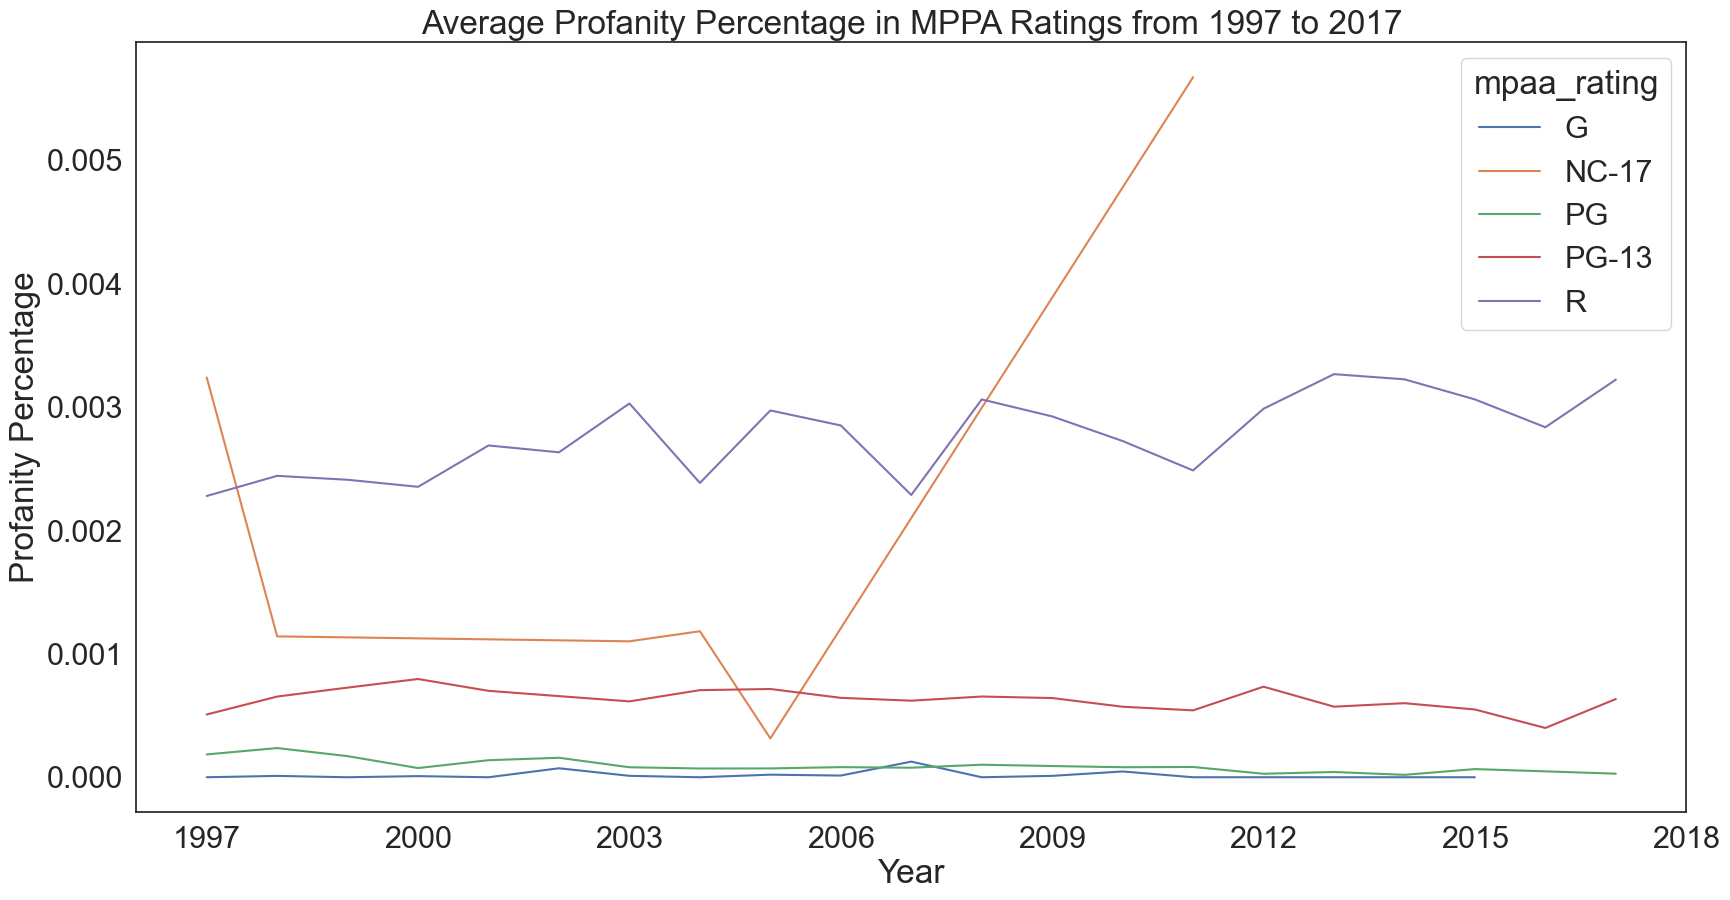

In [37]:
dfTemp = dfTotal[(dfTotal.mpaa_rating != 'Not Rated') & (dfTotal.mpaa_rating != 'TV-MA') & (dfTotal.mpaa_rating != 'Unrated')]
ratingCountsMean = pd.DataFrame(dfTemp.groupby(['release_date','mpaa_rating']).mean()['normTotal'])
ax = sns.lineplot(data = ratingCountsMean, x='release_date', y = 'normTotal',hue = 'mpaa_rating')
ax.set(title = "Average Profanity Percentage in MPPA Ratings from 1997 to 2017",
       ylabel = "Profanity Percentage",
       xlabel = "Year")
xy = [1997,2000,2003,2006,2009,2012,2015,2018]
ax.set_xticks(xy)

We can see that the NC-17 rating changes the most out of all ratings in terms of profane percentages. Of note is that although NC-17 is above R in terms of restrictions, From 1997 to 2007 R rated movies on average had higher percantages of profane words than NC-17 movies. G, PG, and PG-13 movies all had uniform average profane percantages over time, with R exhibiting a peak and valley pattern as well. 

To see how well the average percantage of profane words determines the MPAA Rating, let's try a K-Nearest Neighbours algorithm to train a classifer that determines the MPAA rating based solely on the profane percantage feature. We'll train a new model for every year of the dataset.

/Users/victorwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/victorwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/victorwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed w

Text(0.5, 1.0, 'KNN Model Accuracy per year from 1997 to 2017')

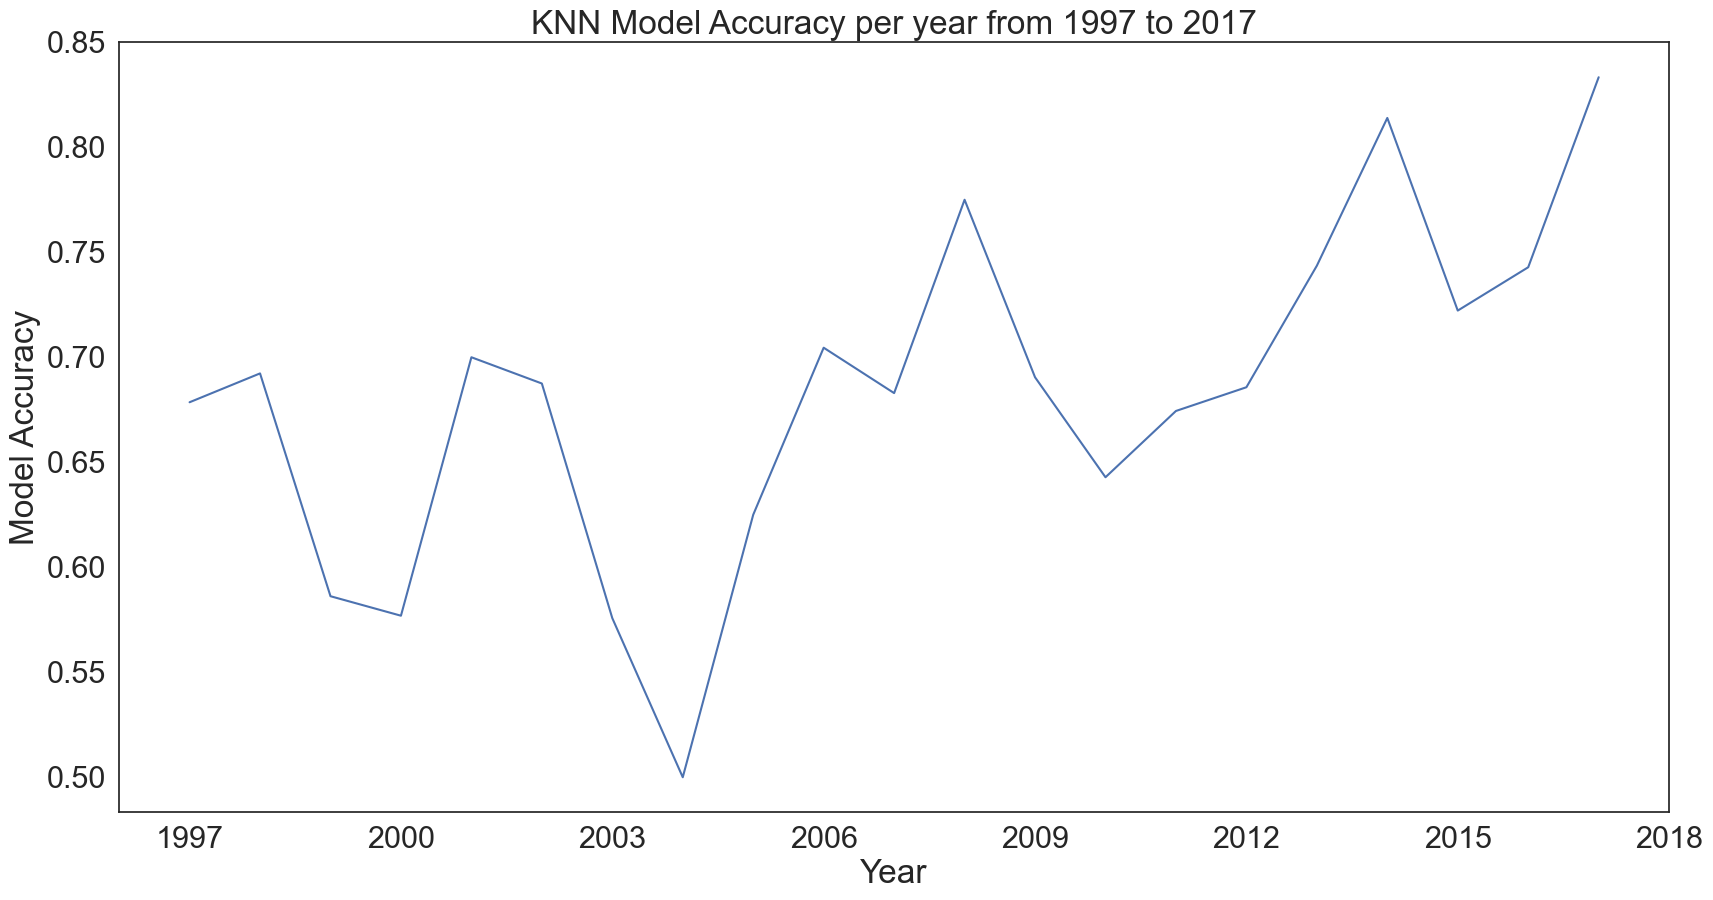

In [43]:
def knnPrediction(data):  
    data = data[(data.mpaa_rating != 'Not Rated') & (data.mpaa_rating != 'TV-MA') & (data.mpaa_rating != 'Unrated')]
    X = data['normTotal'].values.reshape(-1,1)
    y = data['mpaa_rating'].values.reshape(-1,1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

    knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)

    accuracy = knn.score(X_test, y_test)
    return accuracy

predictResults = dfPredict.groupby('release_date').apply(knnPrediction)
plt.plot(predictResults)
plt.xticks(xy)
plt.xlabel("Year")
plt.ylabel("Model Accuracy")
plt.title("KNN Model Accuracy per year from 1997 to 2017")


From the results, we can see that profanity was the best predictor of the MPAA rating in 2017, and the worst predictor in 2004. We can also note an increased importance in the role of profanity in the MPAA rating over time as well.

We'll use a time series analysis to look at the trends in profanity percantage and see possible predictions for future profanity averages. First, we'll perform a Dickey Fuller test to check for stationarity in our data.     

In [298]:
percentCountsMean = pd.DataFrame(dfTotal.groupby('release_date').mean()['normTotal'])
adft = adfuller(percentCountsMean,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3]], "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used"]})
print(output_df)

      Values                       Metric
0  -4.568002              Test Statistics
1   0.000148                      p-value
2   8.000000             No. of lags used
3  12.000000  Number of observations used


Looking at our results, we can see that we have a low enough p value that we can reject the null hypothesis of no stationarity. We'll also verify autocorrelation across different lagging years to determine the correlation between values with different past values.

In [299]:
autocorrelation_lag1 = percentCountsMean['normTotal'].autocorr(lag=1)
print("One Year Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = percentCountsMean['normTotal'].autocorr(lag=3)
print("Three Year Lag: ", autocorrelation_lag3)

autocorrelation_lag9 = percentCountsMean['normTotal'].autocorr(lag=9)
print("Nine  Lag: ", autocorrelation_lag9)

One Year Lag:  0.42275211333448615
Three Year Lag:  0.035968634623145035
Nine  Lag:  -0.530720118914236


We can see that the data exhibits correlation for the one and nine year lags, but for the three year lag the autocorrelation drops significantly. Let's take a look at the decomposition to the trend and seasonality in the data. 

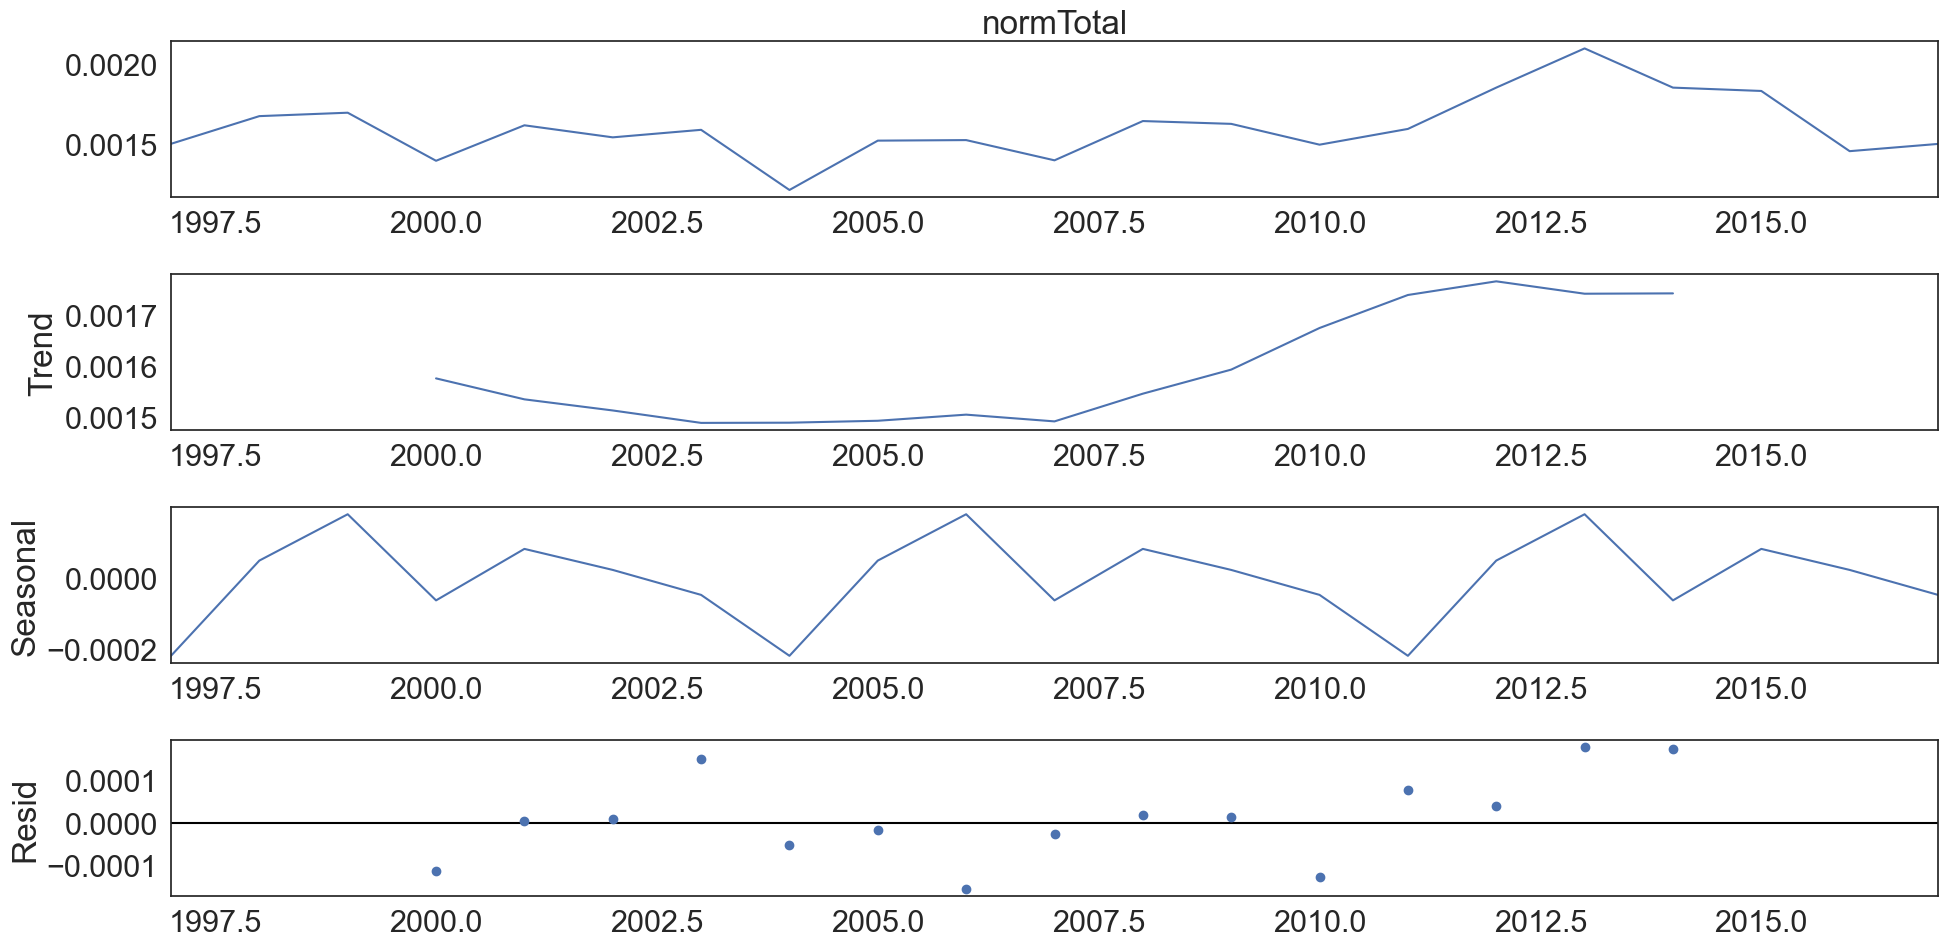

In [34]:
percentCountsMean['Years'] = [1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
percentCountsMean.index = percentCountsMean['Years']
decompose = seasonal_decompose(percentCountsMean['normTotal'],model='additive', period=7)
decompose.plot()
plt.show()

From the breakdown, we can see clearly the decreasing of profanity percantages from 1997 to 2002 followed by a plateau until 2007. Then we see the increase in profanity from 2007 to 2012 before plateauing again in 2012. The seasonality graph shows the 8 year seasonal pattern, which is a peak followed by a decrease for 2 years, a rise for 1 year, a decrease for 3 years, and a rise again for 2 years. We also note the high variability in the data from 2011 onwards relative to the previous years. Next, we'll fit an ARIMA model to the data to try and forecast the next five years of profanity and see how average profanity rates would change.

In [45]:
model = ARIMA(percentCountsMean['normTotal'], order=(5,1,0))
fit = model.fit()
predictions = model.fit().predict()

print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:              normTotal   No. Observations:                   21
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 143.030
Date:                Tue, 21 Mar 2023   AIC                           -274.060
Time:                        10:12:02   BIC                           -268.086
Sample:                             0   HQIC                          -272.894
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3016      0.181     -1.670      0.095      -0.656       0.052
ar.L2         -0.2623      0.144     -1.822      0.068      -0.544       0.020
ar.L3         -0.3919      0.146     -2.684      0.0

/Users/victorwang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/victorwang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/victorwang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'Predicted vs Actual Profanity Percentages')

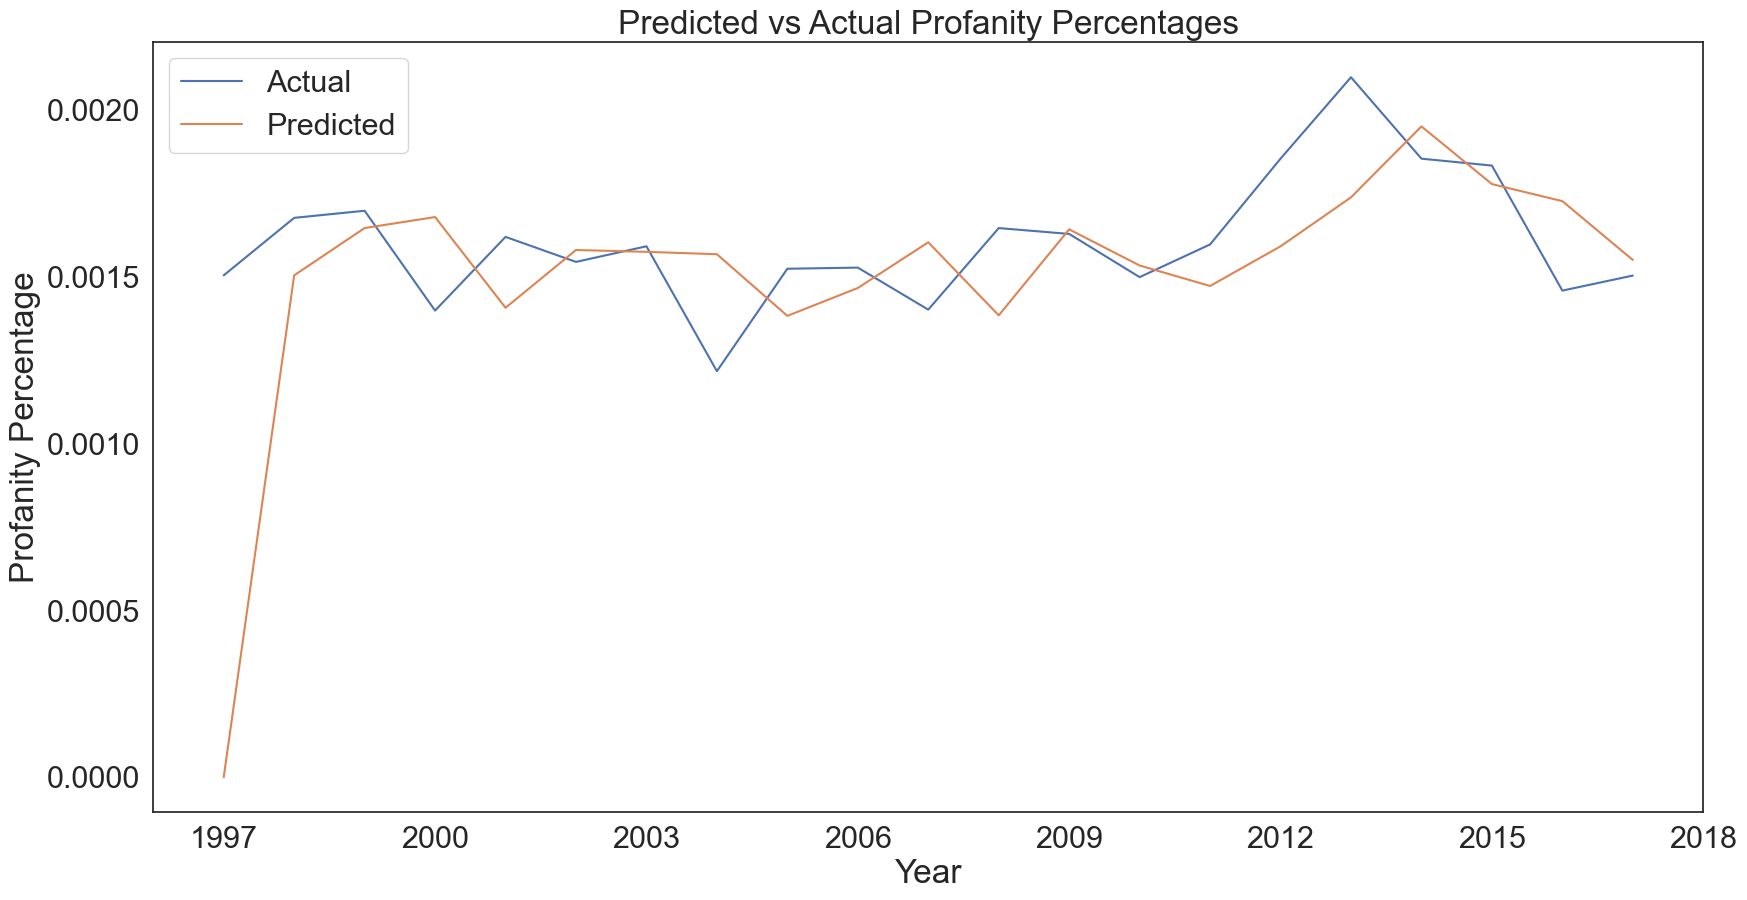

In [46]:
plt.plot(percentCountsMean['normTotal'], label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.xticks(xy)
plt.xlabel("Year")
plt.ylabel("Profanity Percentage")
plt.title("Predicted vs Actual Profanity Percentages")


In [47]:
fit.forecast(steps = 5)

/Users/victorwang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


21    0.001580
22    0.001763
23    0.001754
24    0.001772
25    0.001669
Name: predicted_mean, dtype: float64

Looking at our forecasted profanity, we can see that the model predicts one more year of decreasing profanity usage in movies, followed by an uptick for another three years before dropping again.